In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import cohen_kappa_score 
from sklearn.metrics import accuracy_score

password = getpass.getpass()
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

import warnings
warnings.filterwarnings('ignore')

········


###  1. Create a query or queries to extract the information you think may be relevant for building the prediction model. 
### It should include some film features and some rental features.


In [2]:
query = """SELECT 	F.film_id, 
		F.release_year, 
        F.rental_duration, 
        F.rental_rate, 
        F.replacement_cost,
        F.length, 
        F.rating, 
        COUNT(R.rental_id) as num_rentals
FROM film F
LEFT JOIN inventory I USING (film_id)
LEFT JOIN rental R USING (inventory_id)
GROUP BY F.film_id; 
"""


### 2. Read the data into a Pandas dataframe.

In [3]:
data = pd.read_sql_query(query, engine)
data.head()

,film_id,release_year,rental_duration,rental_rate,replacement_cost,length,rating,num_rentals
0,1,2006,6,0.99,20.99,86,PG,24
1,2,2006,3,4.99,12.99,48,G,7
2,3,2006,7,2.99,18.99,50,NC-17,12
3,4,2006,5,2.99,26.99,117,G,23
4,5,2006,6,2.99,22.99,130,G,12


### 3. Analyze extracted features and transform them. 
### You may need to encode some categorical variables, or scale numerical variables.

In [4]:
data.shape

(1000, 8)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   film_id           1000 non-null   int64  
 1   release_year      1000 non-null   int64  
 2   rental_duration   1000 non-null   int64  
 3   rental_rate       1000 non-null   float64
 4   replacement_cost  1000 non-null   float64
 5   length            1000 non-null   int64  
 6   rating            1000 non-null   object 
 7   num_rentals       1000 non-null   int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 62.6+ KB


In [6]:
data.isna().sum()

film_id             0
release_year        0
rental_duration     0
rental_rate         0
replacement_cost    0
length              0
rating              0
num_rentals         0
dtype: int64

In [7]:
# The types of the columns are ok and there are no NaN values
# looks like the data is pretty clean

### EDA

In [8]:
# split into numerical and categorical
data_cat = data.select_dtypes(include = np.object)
data_num = data.select_dtypes(include = np.number)


In [9]:
# only one categorical variable: Rating

rating_count = data_cat.rating.value_counts()
rating_count 

PG-13    223
NC-17    210
R        195
PG       194
G        178
Name: rating, dtype: int64

<AxesSubplot:>

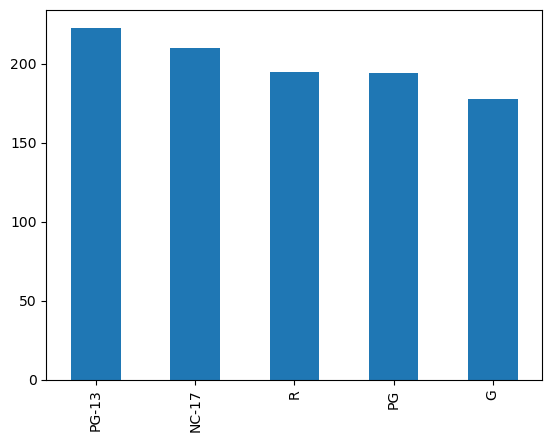

In [10]:
rating_count.plot(kind = "bar")

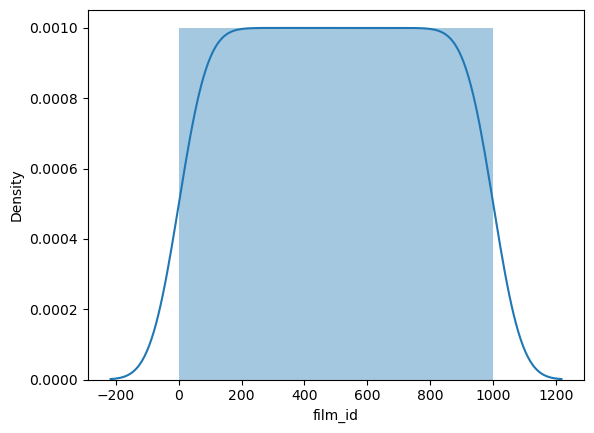

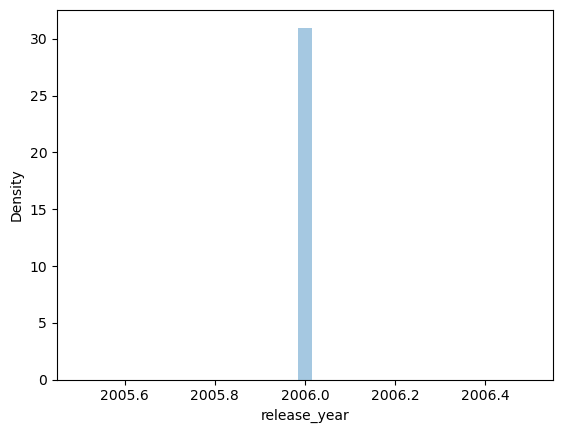

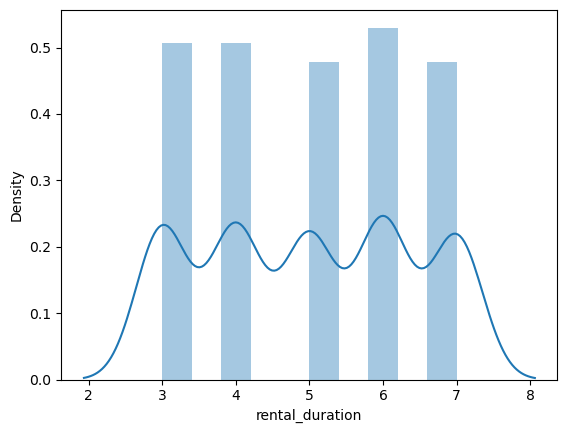

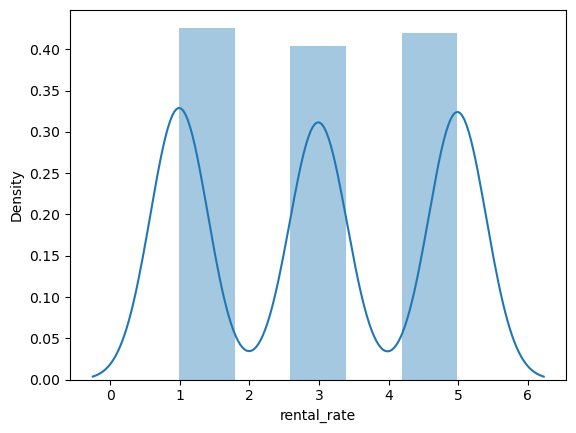

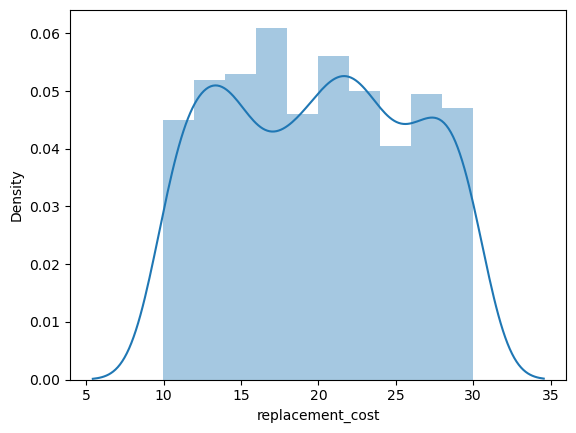

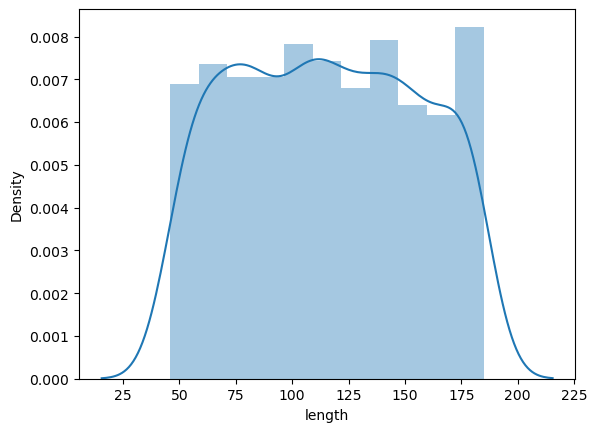

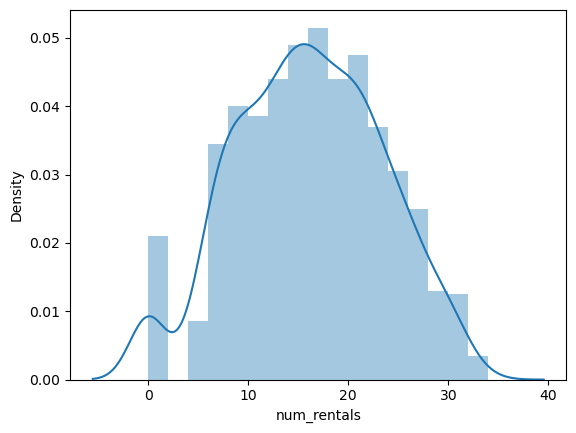

In [11]:
# numericals 
for column in data_num.columns:
    sns.distplot(data_num[column])
    plt.show()

In [12]:
data.release_year.value_counts()

2006    1000
Name: release_year, dtype: int64

In [13]:
# drop columns film_id (1 value/row) and release_year (only one value, 2006)

data_num = data_num.drop(["film_id", "release_year"], axis = 1)

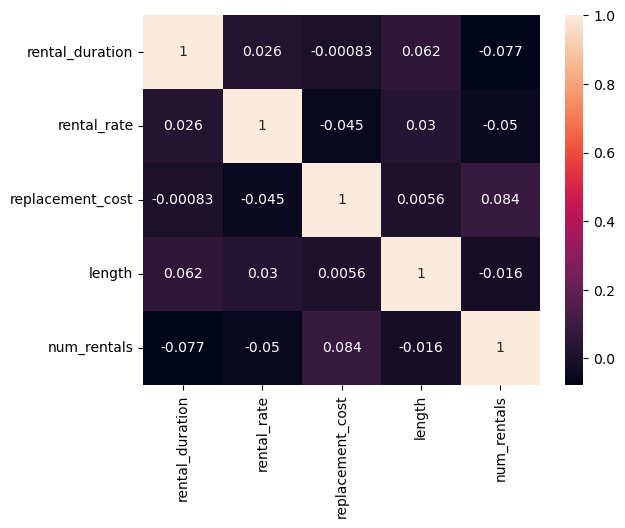

In [14]:
corr_matrix = data_num.corr()
sns_plot = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [15]:
# the correlation between features is low

### Transformations

In [16]:
# scale numerical features

transformer = MinMaxScaler().fit(data_num)
data_num_minmax = transformer.transform(data_num) 
data_num_norm = pd.DataFrame(data_num_minmax,columns= data_num.columns)
data_num_norm.head()

,rental_duration,rental_rate,replacement_cost,length,num_rentals
0,0.75,0.0,0.55,0.287770,0.705882
1,0.00,1.0,0.15,0.014388,0.205882
2,1.00,0.5,0.45,0.028777,0.352941
3,0.50,0.5,0.85,0.510791,0.676471
4,0.75,0.5,0.65,0.604317,0.352941


In [17]:
# encoding categorical feature

data_cat_dumm = pd.get_dummies(data_cat, drop_first=True)
data_cat_dumm.head()

,rating_NC-17,rating_PG,rating_PG-13,rating_R
0,0,1,0,0
1,0,0,0,0
2,1,0,0,0
3,0,0,0,0
4,0,0,0,0


In [18]:
# concat dataframes

X = pd.concat([data_num_norm, data_cat_dumm], axis=1)
X.head()

,rental_duration,rental_rate,replacement_cost,length,num_rentals,rating_NC-17,rating_PG,rating_PG-13,rating_R
0,0.75,0.0,0.55,0.287770,0.705882,0,1,0,0
1,0.00,1.0,0.15,0.014388,0.205882,0,0,0,0
2,1.00,0.5,0.45,0.028777,0.352941,1,0,0,0
3,0.50,0.5,0.85,0.510791,0.676471,0,0,0,0
4,0.75,0.5,0.65,0.604317,0.352941,0,0,0,0


### 4. Create a query to get the list of films and a boolean indicating if it was rented last month. 
### This would be our target variable.


In [19]:
# first, check the rents per month to see which is the last month

query = """SELECT 	date_format(CONVERT(R.rental_date,date), '%Y') as rental_year,
        date_format(CONVERT(R.rental_date,date), '%M') as rental_month, 
		COUNT(rental_id) AS num_rentals
FROM film F
LEFT JOIN inventory I USING (film_id)
LEFT JOIN rental R USING (inventory_id)
GROUP BY rental_year, rental_month;"""

In [20]:
# monthly_rentals = pd.read_sql_query(query, engine)
# monthly_rentals.head()

This gets an error in python but works in mysql (¿?) <br>
There are some rentals in the last month, february 2006 (182) <br>
They may seem few, but if we go to the previous month, july 2005, which has 6709 rentals, we see that almost all films have been rented. Therefore I continue with february 2006.


In [21]:
# query to obtain the films that were rented in february 2006
# first filter between may 2005 and february 2006 to leave out the row with 1 rental in feb 2023
# then filter to get only the ones that were rented in feb 2006 and right join with film
# the film ids that where not rented in feb 2006 will have NaNs

query = """WITH max_date as (SELECT 	F.film_id, 
        MAX(R.rental_date) as max_rental_date
FROM film F
LEFT JOIN inventory I USING (film_id)
LEFT JOIN rental R USING (inventory_id)
WHERE R.rental_date BETWEEN "2005-05-01 00:00:00" AND "2006-03-01 00:00:00"
GROUP BY F.film_id)
SELECT F.film_id, MD.max_rental_date AS rents_feb_2006
FROM (	SELECT film_id, max_rental_date 
		FROM max_date 
        WHERE max_rental_date BETWEEN "2006-02-01 00:00:00" AND "2006-03-01 00:00:00") 
        AS MD
RIGHT JOIN film F
USING (film_id);"""

feb_rentals =  pd.read_sql_query(query, engine)
feb_rentals.head()

,film_id,rents_feb_2006
0,1,NaT
1,2,2006-02-14 15:16:03
2,3,NaT
3,4,2006-02-14 15:16:03
4,5,2006-02-14 15:16:03


In [22]:
feb_rentals.isna().sum()

film_id             0
rents_feb_2006    832
dtype: int64

In [23]:
# fill NaN values with 0 and replace other values with 1
feb_rentals = feb_rentals.fillna(0)
feb_rentals["rents_feb_2006"] = feb_rentals["rents_feb_2006"].apply(lambda x: 1 if x != 0 else x)
feb_rentals["rents_feb_2006"].value_counts()

0    832
1    168
Name: rents_feb_2006, dtype: int64

In [24]:
# drop film_id column to get target (y)

y = feb_rentals.drop("film_id", axis = 1)
y

,rents_feb_2006
0,0
1,1
2,0
3,1
4,1
...,...
995,0
996,0
997,1
998,0


### 5. Create a logistic regression model to predict this variable from the cleaned data.


In [25]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [26]:
# train with logistic regression
classification = LogisticRegression(random_state=0).fit(X_train, y_train)

In [27]:
# predictions with test
predictions = classification.predict(X_test)

### 6. Evaluate the results.

In [28]:
pd.Series(predictions).value_counts()

0    300
dtype: int64

In [29]:
y_test.value_counts()

rents_feb_2006
0                 251
1                  49
dtype: int64

The accuracy of the model on test set is: 0.84 
[[251   0]
 [ 49   0]]


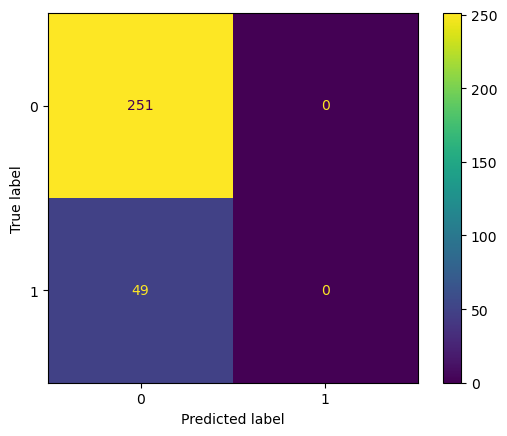

The Kappa of your model is: 0.00


In [30]:
print("The accuracy of the model on test set is: %4.2f " % accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
plot_confusion_matrix(classification, X_test, y_test)  
plt.show() 
print("The Kappa of your model is: %4.2f" % (cohen_kappa_score(y_test, predictions)))

Interpretation: <br>
While an accuracy of 84% may seem good, the Kappa coefficient of 0 suggests that the model is not performing better than random guessing. <br>
The reason may be because of the data used as target: 182 rented films against 818 not rented.

In [31]:
# let's try with data from next month: august 2005

query = """WITH max_date as (SELECT 	F.film_id, 
        MAX(R.rental_date) as max_rental_date
FROM film F
LEFT JOIN inventory I USING (film_id)
LEFT JOIN rental R USING (inventory_id)
WHERE R.rental_date BETWEEN "2005-05-01 00:00:00" AND "2005-09-01 00:00:00"
GROUP BY F.film_id)
SELECT F.film_id, MD.max_rental_date AS rents_aug_2005
FROM (	SELECT film_id, max_rental_date 
		FROM max_date 
        WHERE max_rental_date BETWEEN "2005-08-01 00:00:00" AND "2005-09-01 00:00:00") 
        AS MD
RIGHT JOIN film F
USING (film_id);"""

aug_rentals =  pd.read_sql_query(query, engine)
aug_rentals.head()

,film_id,rents_aug_2005
0,1,2005-08-23 01:01:01
1,2,2005-08-22 16:59:05
2,3,2005-08-23 13:54:39
3,4,2005-08-22 21:16:54
4,5,2005-08-19 09:07:13


In [32]:
aug_rentals.isna().sum()

film_id            0
rents_aug_2005    42
dtype: int64

The accuracy of the model on test set is: 0.96 
[[  0  13]
 [  0 287]]


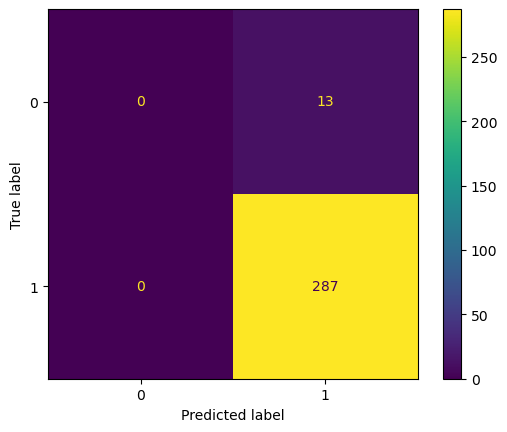

The Kappa of your model is: 0.00


In [33]:
aug_rentals = aug_rentals.fillna(0)
aug_rentals["rents_aug_2005"] = aug_rentals["rents_aug_2005"].apply(lambda x: 1 if x != 0 else x)


y = aug_rentals.drop("film_id", axis = 1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
classification = LogisticRegression(random_state=0).fit(X_train, y_train)
predictions = classification.predict(X_test)

print("The accuracy of the model on test set is: %4.2f " % accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
plot_confusion_matrix(classification, X_test, y_test)  
plt.show() 
print("The Kappa of your model is: %4.2f" % (cohen_kappa_score(y_test, predictions)))

Same result... but the other way around. This time the prediction is that all the movies will be rented. 

In [34]:
# different approach (suggested by Isi): use data from all months and evaluate films regarding popularity

query = """WITH my_cte as (SELECT 	F.film_id, 
        COUNT(R.rental_id) as num_rentals
FROM film F
LEFT JOIN inventory I USING (film_id)
LEFT JOIN rental R USING (inventory_id)
GROUP BY F.film_id)
SELECT F.film_id, R.avg_rentals
FROM (SELECT film_id, AVG(num_rentals) as avg_rentals
FROM my_cte 
GROUP BY film_id
HAVING avg_rentals > (SELECT AVG(num_rentals) FROM my_cte)) AS R
RIGHT JOIN film F
USING (film_id);"""


pop_films =  pd.read_sql_query(query, engine)
pop_films.head()

,film_id,avg_rentals
0,1,24.0
1,2,NaN
2,3,NaN
3,4,23.0
4,5,NaN


In [35]:
pop_films.isna().sum()

film_id          0
avg_rentals    525
dtype: int64

The accuracy of the model on test set is: 0.98 
[[156   0]
 [  6 138]]


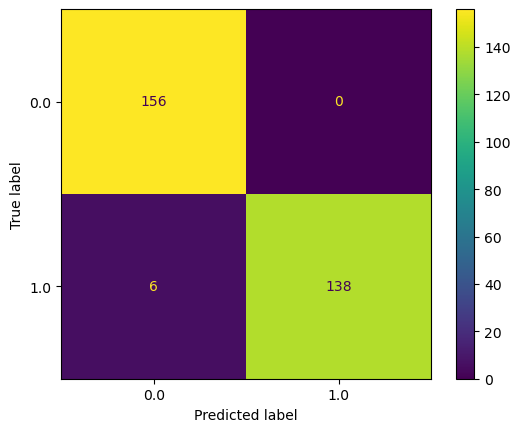

The Kappa of your model is: 0.96


In [36]:
# films with average rentals lower than average = 0, films with average rentals higher than average = 1 
pop_films = pop_films.fillna(0)
pop_films["avg_rentals"] = pop_films["avg_rentals"].apply(lambda x: 1 if x != 0 else x)


y = pop_films.drop("film_id", axis = 1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
classification = LogisticRegression(random_state=0).fit(X_train, y_train)
predictions = classification.predict(X_test)

print("The accuracy of the model on test set is: %4.2f " % accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
plot_confusion_matrix(classification, X_test, y_test)  
plt.show() 
print("The Kappa of your model is: %4.2f" % (cohen_kappa_score(y_test, predictions)))

Here the result of the model is much better (it's logical since the target depends highly on one of the features in X, num_rentals). 